**Capstone Project - Herwin Yudha Setyawan**

**Data Classification and Summarization Using IBM Granite x Hacktiv8**

Dibagi tiap langkah, total ada 7.

Tiap langkah ada sel.

Deteksi Berita Hoaks Indo - Dataset | Dataset RAW

https://www.kaggle.com/datasets/mochamadabdulazis/deteksi-berita-hoaks-indo-dataset/data

**Langkah 1: Instalasi dan Setup Awal**

In [1]:
# Sel 1: Instalasi Library
# Menginstal semua library yang dibutuhkan.
!pip install -q pandas matplotlib seaborn wordcloud scikit-learn tqdm langchain_community replicate

print("✅ Library yang dibutuhkan sudah terinstal.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
✅ Library yang dibutuhkan sudah terinstal.


In [2]:
# Sel 2: Import Library dan Konfigurasi API Key
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from tqdm.auto import tqdm
from google.colab import userdata

# Untuk evaluasi model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Untuk memanggil model dari Replicate
from langchain_community.llms import Replicate

# --- KONFIGURASI API KEY ---
try:
    api_token = userdata.get('REPLICATE_API_TOKEN')
    os.environ["REPLICATE_API_TOKEN"] = api_token
    print("✅ REPLICATE_API_TOKEN berhasil dikonfigurasi dari Colab Secrets.")
except userdata.SecretNotFoundError:
    print("⚠️ Secret 'REPLICATE_API_TOKEN' tidak ditemukan. Mohon ditambahkan terlebih dahulu.")

✅ REPLICATE_API_TOKEN berhasil dikonfigurasi dari Colab Secrets.


**Langkah 2: Memuat dan Membersihkan Data**

In [3]:
# Sel 3: Muat dan Gabungkan Semua File CSV
# Daftar file RAW yang sudah diupload tadi 4 csv
raw_files = [
    'turnbackhoax_2020_2025.csv',
    'cnnindonesia_news_RAW.csv',
    'detikcom_news_RAW.csv',
    'kompas_news_RAW.csv'
]

list_df = []
for file in raw_files:
    try:
        df_temp = pd.read_csv(file)
        # Membuat label 'HOAX' atau 'VALID' berdasarkan nama file
        df_temp['label'] = 'HOAX' if 'turnbackhoax' in file else 'VALID'
        list_df.append(df_temp)
        print(f"File '{file}' berhasil dimuat.")
    except FileNotFoundError:
        print(f"⚠️ Peringatan: File '{file}' tidak ditemukan.")

# Gabungkan semua dataframe menjadi satu
df_full = pd.concat(list_df, ignore_index=True)
print("\n✅ Semua data berhasil digabungkan.")

File 'turnbackhoax_2020_2025.csv' berhasil dimuat.
File 'cnnindonesia_news_RAW.csv' berhasil dimuat.
File 'detikcom_news_RAW.csv' berhasil dimuat.
File 'kompas_news_RAW.csv' berhasil dimuat.

✅ Semua data berhasil digabungkan.


In [4]:
# Sel 4: Pembersihan dan Standarisasi Data
# Standarisasi nama kolom. Hanya akan disesuaikan jika nama kolom aslinya berbeda.
df_full.rename(columns={'isi_berita': 'text', 'judul': 'title'}, inplace=True)

# Pilih hanya kolom yang dibutuhkan
df_clean = df_full[['title', 'text', 'label']].copy()

# Hapus data yang kosong di kolom 'text' atau 'title'
df_clean.dropna(subset=['text', 'title'], inplace=True)

# Hapus data duplikat berdasarkan kolom text
df_clean.drop_duplicates(subset=['text'], inplace=True)

# Buat kolom baru dengan menggabungkan judul dan isi berita
df_clean['full_text'] = df_clean['title'] + ". " + df_clean['text']

# Reset index setelah membuang baris
df_final = df_clean.reset_index(drop=True)

print("✅ Data berhasil dibersihkan dan distandarisasi.")
print("\nDistribusi Label pada Dataset Final:")
print(df_final['label'].value_counts())

✅ Data berhasil dibersihkan dan distandarisasi.

Distribusi Label pada Dataset Final:
label
HOAX     12648
VALID    12646
Name: count, dtype: int64


**Langkah 3: Analisis Data Eksploratif (EDA)**

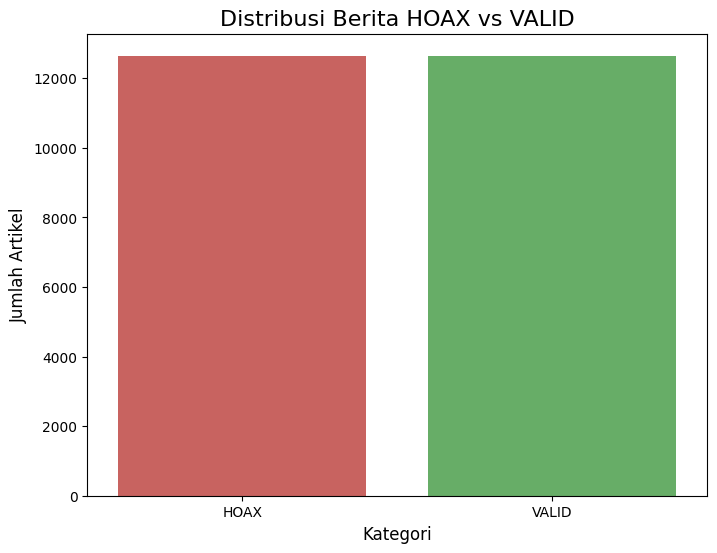

In [6]:
# Sel 5: Visualisasi Distribusi Label
plt.figure(figsize=(8, 6))

# PERBAIKAN: Tambahkan hue='label' dan legend=False untuk menghilangkan warning
sns.countplot(x='label', data=df_final, palette={'HOAX': '#d9534f', 'VALID': '#5cb85c'}, hue='label', legend=False)

plt.title('Distribusi Berita HOAX vs VALID', fontsize=16)
plt.xlabel('Kategori', fontsize=12)
plt.ylabel('Jumlah Artikel', fontsize=12)
plt.show()

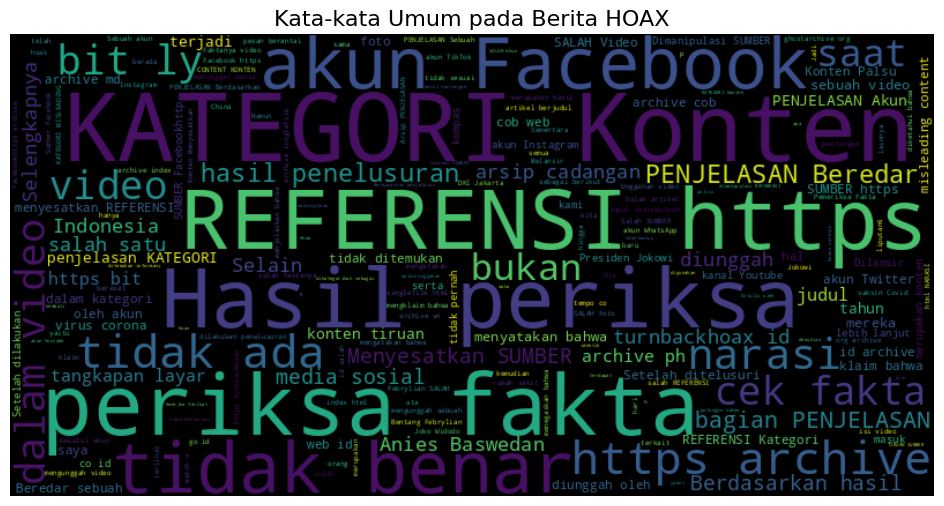

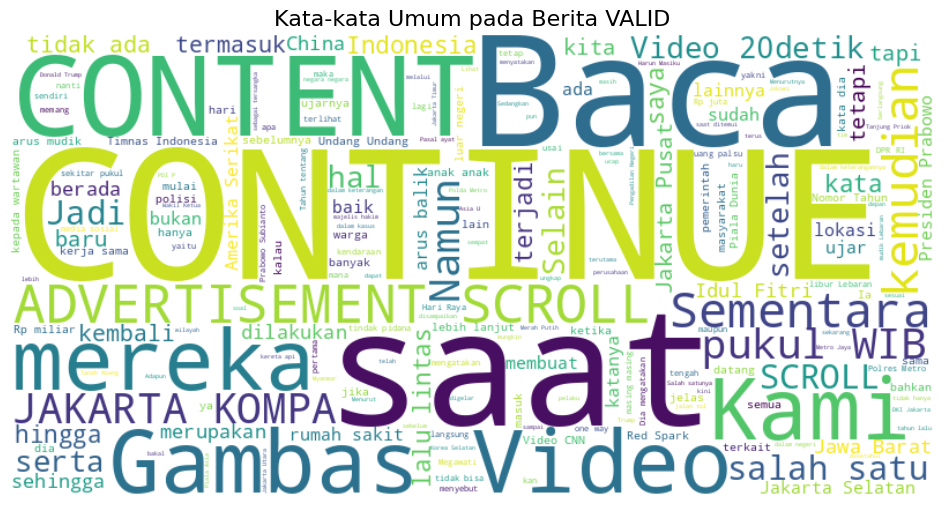

In [7]:
# Sel 6: Word Cloud untuk HOAX dan VALID
# Himpunan kata-kata umum dalam Bahasa Indonesia untuk diabaikan
stopwords_indonesia = set(STOPWORDS)
stopwords_indonesia.update(['sih', 'nya', 'dan', 'yg', 'di', 'dari', 'ke', 'ini', 'itu', 'atau', 'pada', 'dengan', 'yang', 'untuk', 'juga', 'akan', 'adalah', 'tersebut', 'karena', 'seperti'])

# Word Cloud untuk Berita HOAX
text_hoax = ' '.join(df_final[df_final['label'] == 'HOAX']['full_text'])
wordcloud_hoax = WordCloud(width=800, height=400, background_color='black', stopwords=stopwords_indonesia).generate(text_hoax)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_hoax, interpolation='bilinear')
plt.axis('off')
plt.title('Kata-kata Umum pada Berita HOAX', fontsize=16)
plt.show()

# Word Cloud untuk Berita VALID
text_valid = ' '.join(df_final[df_final['label'] == 'VALID']['full_text'])
wordcloud_valid = WordCloud(width=800, height=400, background_color='white', colormap='viridis', stopwords=stopwords_indonesia).generate(text_valid)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_valid, interpolation='bilinear')
plt.axis('off')
plt.title('Kata-kata Umum pada Berita VALID', fontsize=16)
plt.show()

**Langkah 4: Konfigurasi Model dan Fungsi AI**

In [8]:
# Sel 7: Inisialisasi Model IBM Granite dari Replicate
model_id = "ibm-granite/granite-3.3-8b-instruct"
llm = Replicate(
    model=model_id,
    model_kwargs={"temperature": 0.1, "max_new_tokens": 512} # Parameter menyesuaikan duit :D
)
print(f"✅ Model {model_id} dari Replicate siap digunakan.")

✅ Model ibm-granite/granite-3.3-8b-instruct dari Replicate siap digunakan.


In [9]:
# Sel 8: Membuat Fungsi untuk Klasifikasi dan Peringkasan
def classify_news(news_text):
    prompt = f"""Tugas: Klasifikasikan teks berita berikut ke dalam salah satu dari dua kategori: HOAX atau VALID. Berikan hanya nama kategorinya saja sebagai jawaban.

Teks Berita: "{news_text[:2500]}"

Kategori:"""
    try:
        prediction = llm.invoke(prompt).strip().upper()
        return 'HOAX' if 'HOAX' in prediction else 'VALID' if 'VALID' in prediction else "TIDAK DIKETAHUI"
    except Exception as e:
        return "ERROR"

def summarize_news(news_text):
    prompt = f"""Tugas: Buat ringkasan dari artikel berita berikut dalam 3 poin utama yang netral dan informatif.

Artikel Berita: "{news_text[:4000]}"

Ringkasan:"""
    try:
        return llm.invoke(prompt).strip()
    except Exception as e:
        return "ERROR SAAT MEMBUAT RINGKASAN"

print("✅ Fungsi AI (klasifikasi & peringkasan) siap digunakan.")

✅ Fungsi AI (klasifikasi & peringkasan) siap digunakan.


**Langkah 5: Menjalankan Analisis dan Evaluasi**

In [10]:
# Sel 9: Menjalankan Klasifikasi pada Sampel Data
# Mengambil sampel 100 berita untuk efisiensi
df_sample = df_final.sample(n=100, random_state=42).copy()

# Menggunakan tqdm untuk melihat progress bar saat proses berjalan
tqdm.pandas(desc="Mengklasifkasi Berita")
df_sample['predicted_label'] = df_sample['full_text'].progress_apply(classify_news)

print("\n✅ Klasifikasi pada sampel selesai.")
print(df_sample[['label', 'predicted_label', 'title']].head(10))

Mengklasifkasi Berita:   0%|          | 0/100 [00:00<?, ?it/s]


✅ Klasifikasi pada sampel selesai.
       label  predicted_label  \
14913  VALID            VALID   
23580  VALID             HOAX   
14930  VALID             HOAX   
7819    HOAX             HOAX   
7217    HOAX             HOAX   
8918    HOAX             HOAX   
3498    HOAX  TIDAK DIKETAHUI   
397     HOAX             HOAX   
19530  VALID             HOAX   
20225  VALID             HOAX   

                                                   title  
14913  Arus Balik 7 April: One Way Nasional - Contraf...  
23580  Mayat Perempuan Bercelana Doraemon Ditemukan d...  
14930  Prediksi Formasi Timnas Indonesia U-17 vs Yama...  
7819   [SALAH]: Pria Asal Solo Meninggal Dunia Akibat...  
7217   [SALAH] Beberapa vaksin COVID-19 dapat meningk...  
8918   [SALAH] Lowongan Kerja PT. Tempo Scan Pacific Tbk  
3498   [SALAH] Banjir Bandang Hancurkan Ribuan Rumah ...  
397    [SALAH] Prabowo Pecat Hakim yang Vonis Harvey ...  
19530  Getaran Gempa M 5 Cilacap Dirasakan di Bantul ...  
20225  One

Akurasi Model Granite: 71.88%

Laporan Klasifikasi:
              precision    recall  f1-score   support

        HOAX       0.67      1.00      0.80        55
       VALID       1.00      0.34      0.51        41

    accuracy                           0.72        96
   macro avg       0.84      0.67      0.66        96
weighted avg       0.81      0.72      0.68        96



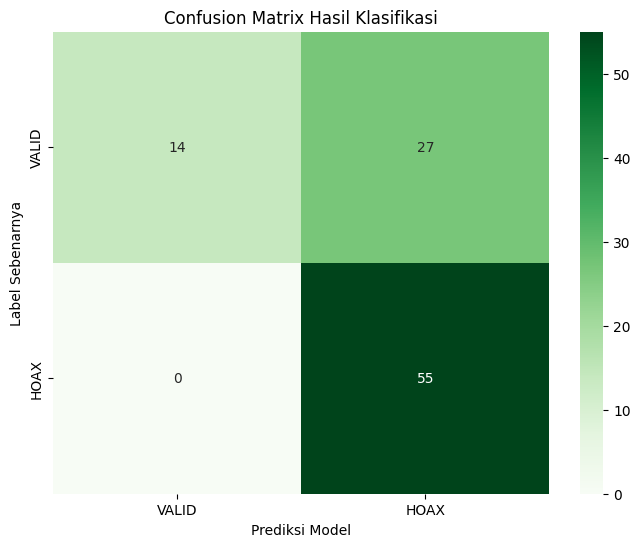

In [11]:
# Sel 10: Evaluasi Performa Klasifikasi
# Filter hasil yang valid untuk evaluasi
eval_df = df_sample[df_sample['predicted_label'].isin(['HOAX', 'VALID'])]

y_true = eval_df['label']
y_pred = eval_df['predicted_label']

print(f"Akurasi Model Granite: {accuracy_score(y_true, y_pred):.2%}\n")
print("Laporan Klasifikasi:")
print(classification_report(y_true, y_pred))

# Visualisasi Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=['VALID', 'HOAX'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['VALID', 'HOAX'], yticklabels=['VALID', 'HOAX'])
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix Hasil Klasifikasi')
plt.show()

In [13]:
# Sel 10.1: Simpan Hasil Klasifikasi ke File CSV dan Download
from google.colab import files

# Nama file untuk menyimpan hasil
nama_file_hasil = 'hasil_klasifikasi_100_artikel.csv'

# Menyimpan dataframe sampel yang sudah ada prediksi modelnya ke file CSV
df_sample.to_csv(nama_file_hasil, index=False)

print(f"✅ Hasil klasifikasi berhasil disimpan ke file '{nama_file_hasil}'.")

# Memicu proses download file tersebut ke komputermu
files.download(nama_file_hasil)

print(f"🚀 File '{nama_file_hasil}' sedang di-download...")

# Didownload untuk menghemat duit di replicate ✅
print(f"✅ File hasil_klasifikasi_100_artikel.csv sudah di-download...")

✅ Hasil klasifikasi berhasil disimpan ke file 'hasil_klasifikasi_100_artikel.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🚀 File 'hasil_klasifikasi_100_artikel.csv' sedang di-download...
✅ File hasil_klasifikasi_100_artikel.csv sudah di-download...


**Langkah 6: Menjalankan Peringkasan**

In [14]:
# Sel 11: Contoh Peringkasan Artikel
# Ambil satu contoh berita VALID dan satu HOAX untuk diringkas
contoh_valid = df_final[df_final['label'] == 'VALID'].iloc[0]
contoh_hoax = df_final[df_final['label'] == 'HOAX'].iloc[0]

print("--- RINGKASAN BERITA VALID ---")
print(f"Judul: {contoh_valid['title']}\n")
ringkasan_valid = summarize_news(contoh_valid['full_text'])
print(ringkasan_valid)

print("\n" + "="*50 + "\n")

print("--- RINGKASAN BERITA HOAX ---")
print(f"Judul: {contoh_hoax['title']}\n")
ringkasan_hoax = summarize_news(contoh_hoax['full_text'])
print(ringkasan_hoax)

--- RINGKASAN BERITA VALID ---
Judul: Pesan Paskah Uskup Agung Jakarta Kardinal Ignatius Suharyo

1. Kardinal Ignatius Suharyo, Uskup Agung Jakarta, mengingatkan bahwa Tahun Paskah 2025 merupakan momen untuk menunjukkan kepedulian dan upaya membantu orang-orang yang lemah dan dilemahkan, sebagai indikator bakti kepada Tuhan. Suharyo menyarankan bahwa bakti sejati hanya dilihat dari indikatornya, dan sejarah umat Allah yang sudah dibekali dengan segala macam kebaikan tetap luntur jika tidak damai dan seahtera.

2. Suharyo mengajak umat Katolik untuk menjadi "peziarah pengharapan" dan "penabur harapan" pada Tahun Yubileum 2025, dengan tema Peziarah Pengharapan. Ia mendesak umat Katolik untuk mencari cara untuk menjadi penyedia harapan, sambil mengingatkan bahwa perbuatan baik tidak perlu besar, sesuatu sederhana seperti mematuhi aturan lalu lintas dapat memberikan harapan kepada orang lain.

3. Kardinal Suharyo menyoroti beberapa isu kemanusiaan di Indonesia saat ini, termasuk tindak pid

**Langkah 7: Kesimpulan dan Rekomendasi**

**A. Insight & Findings**

1. Wawasan dari Analisis Data Eksploratif (EDA)

Analisis awal pada dataset menunjukkan distribusi data yang sangat seimbang, dengan 12.648 artikel berlabel HOAX dan 12.646 artikel berlabel VALID. Keseimbangan ini merupakan fondasi yang sangat baik untuk membangun dan mengevaluasi model klasifikasi, karena memastikan model tidak cenderung memihak salah satu kelas hanya karena jumlah datanya lebih banyak.

2. Wawasan dari Evaluasi Model AI

Evaluasi terhadap model IBM Granite pada 100 artikel sampel menghasilkan temuan yang sangat spesifik mengenai perilakunya:

    Akurasi Keseluruhan: Model mencapai akurasi sebesar 71.88%, yang menunjukkan kapabilitas dasar yang baik dalam membedakan antara berita hoaks dan valid tanpa pelatihan khusus (secara zero-shot).

    Karakteristik Model: "Sangat Skeptis dan Agresif Terhadap Hoaks"
    Laporan klasifikasi mengungkapkan karakteristik utama dari model ini:

        Sangat Andal Menemukan Hoaks: Model ini memiliki Recall 1.00 untuk kategori HOAX. Artinya, model ini berhasil mengidentifikasi SEMUA berita hoaks dalam sampel uji tanpa ada satupun yang terlewat. Ini menunjukkan model sangat sensitif dan efektif dalam "menangkap" potensi misinformasi.

        Cenderung "Terlalu Curiga": Konsekuensi dari sensitivitasnya yang tinggi adalah model menjadi terlalu "curiga". Ini terlihat dari Recall 0.34 untuk kategori VALID, yang berarti model salah mengklasifikasikan sekitar 66% berita valid sebagai hoaks. Model ini beroperasi dengan prinsip "lebih baik salah menuduh berita benar sebagai hoaks daripada membiarkan satu hoaks lolos".

        Prediksi "VALID" Sangat Terpercaya: Di sisi lain, ketika model sudah yakin dan memprediksi sebuah berita sebagai VALID, prediksinya 100% benar (Precision 1.00). Ini berarti tidak ada satupun berita hoaks yang salah dilabeli sebagai valid oleh model.

Temuan utamanya adalah model ini tidak hanya sekadar mengklasifikasi, tetapi memiliki "kepribadian" sebagai detektor hoaks yang sangat waspada, yang memprioritaskan penangkapan semua potensi hoaks bahkan dengan risiko menghasilkan positif palsu (false positive).

**B. AI Support Explanation**

Dalam proyek ini, AI dari model IBM Granite (ibm-granite/granite-3.3-8b-instruct) yang diakses melalui platform Replicate dimanfaatkan sebagai alat analisis data utama. Teknik yang digunakan adalah Prompt Engineering dengan pendekatan Zero-Shot Learning, di mana model melakukan tugas tanpa melalui proses fine-tuning atau pelatihan khusus pada dataset ini.

Dukungan AI terbagi menjadi dua fungsi utama:

    Klasifikasi Teks Otomatis: AI diberi instruksi melalui prompt untuk menganalisis konten berita dan mengklasifikasikannya sebagai "HOAX" atau "VALID".

        Contoh Prompt Klasifikasi:
        Tugas: Klasifikasikan teks berita berikut ke dalam salah satu dari dua kategori: HOAX atau VALID. Berikan hanya nama kategorinya saja sebagai jawaban.\n\nTeks Berita: "[Teks artikel]"\n\nKategori:

    Peringkasan Teks Otomatis: AI juga diinstruksikan untuk membaca artikel yang panjang dan membuat ringkasan singkat dalam format poin-poin.

        Contoh Prompt Peringkasan:
        Tugas: Buat ringkasan dari artikel berita berikut dalam 3 poin utama yang netral dan informatif.\n\nArtikel Berita: "[Teks artikel]"\n\nRingkasan:

**C. Conclusion & Recommendations**

**Kesimpulan**

Proyek ini berhasil membuktikan bahwa model bahasa skala besar seperti IBM Granite memiliki kemampuan signifikan untuk melakukan analisis teks berbahasa Indonesia, khususnya dalam tugas deteksi hoaks yang kompleks. Dengan akurasi keseluruhan 71.88% secara zero-shot, model ini menunjukkan potensi besar sebagai alat bantu. Kesimpulan utamanya adalah model ini beroperasi sebagai sistem penyaring hoaks yang sangat sensitif, yang efektif dalam mengidentifikasi semua potensi hoaks namun dengan trade-off berupa tingginya angka positif palsu.

**Rekomendasi**

Berdasarkan temuan di atas, berikut adalah rekomendasi yang konkret dan dapat ditindaklanjuti:

    Implementasi sebagai Sistem Penyaringan Tahap Pertama (First-Pass Screening):
    Mengingat kemampuannya menangkap semua hoaks (Recall 100%), model ini sangat ideal untuk digunakan sebagai alat penyaring otomatis tahap awal. Rekomendasinya adalah mengintegrasikan model ini ke dalam alur kerja redaksi atau platform media sosial untuk menandai (flag) semua konten yang berpotensi hoaks. Konten yang ditandai kemudian dapat diteruskan ke tim fact-checker manusia untuk verifikasi akhir. Cara ini memanfaatkan kekuatan AI tanpa risiko memblokir konten valid secara otomatis.

    Peningkatan Akurasi melalui Fine-Tuning:
    Untuk mengurangi jumlah berita valid yang salah diklasifikasikan, langkah selanjutnya yang sangat disarankan adalah melakukan fine-tuning model Granite. Dengan melatih model secara khusus menggunakan dataset hoaks dan valid berbahasa Indonesia yang lebih besar, model dapat belajar nuansa yang lebih halus, sehingga dapat meningkatkan akurasi sekaligus menyeimbangkan antara Precision dan Recall.

    Pengembangan Fitur "Intisari Berita" untuk Pembaca:
    Kemampuan peringkasan model dapat langsung dimanfaatkan untuk menciptakan fitur bernilai tambah pada portal berita. Rekomendasinya adalah membuat fitur "Lihat Intisari" yang ditenagai oleh AI untuk meringkas artikel-artikel panjang yang sudah terverifikasi valid. Ini akan membantu meningkatkan pengalaman pengguna dengan menyajikan poin-poin kunci secara cepat.

**Github : hysspy**

Deteksi Berita Hoaks Indo - Dataset

https://www.kaggle.com/datasets/mochamadabdulazis/deteksi-berita-hoaks-indo-dataset/data